In [340]:
import itertools
import warnings 
import re
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns
import sympy
from scipy import stats
from collections import OrderedDict
from risk_helpers import *

In [341]:
%matplotlib inline
pd.set_option('display.precision',2)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format',lambda x: '%.4f' % x)

In [342]:
df = pd.read_csv(r'C:\Users\Iulia\Desktop\CreditRisk\german_credit_data.csv')

In [343]:
# Define the mapping
mapping = {'good': 0, 'bad': 1}

# Replace the values in the DataFrame column
df['Risk'] = df['Risk'].replace(mapping)

In [344]:
# Compute missing percentage
missing_percentages = compute_missing_percentage(df)

# Print missing percentages
for column, percentage in missing_percentages.items():
    print(f"{column}: {percentage:.2f}%")

Age: 0.00%
Sex: 0.00%
Job: 0.00%
Housing: 0.00%
Saving accounts: 18.30%
Checking account: 39.40%
Credit amount: 0.00%
Duration: 0.00%
Purpose: 0.00%
Risk: 0.00%


In [345]:
# Delete features with missing percentage above 15%
delete_features_above_threshold(df, 15)

# Replace outliers with whiskers using default multiplier
replace_outliers_with_whiskers(df)

In [346]:
# Define the target variable and independent variables
target = 'Risk'
independent_vars = list(df.columns[df.columns != target])

# Split the data into training and validation sets
train_data, valid_data = train_test_split(df, test_size=0.3, random_state=42)

In [347]:
# Fill missing values with median for numeric and mode for categorical
fill_missing_values(train_data)
fill_missing_values(valid_data)

# Check the resulting dataframe
train_data.head()

,Age,Sex,Job,Housing,Credit amount,Duration,Purpose,Risk
541,60.0000,male,2.0000,free,2032.0000,24.0000,car,0
440,39.0000,male,2.0000,own,1884.0000,12.0000,car,0
482,57.0000,female,2.0000,rent,3622.0000,30.0000,furniture/equipment,0
422,47.0000,male,2.0000,own,958.0000,12.0000,car,0
778,38.0000,male,2.0000,own,5711.0000,36.0000,car,0


In [348]:
# Obtain the WoE dictionary using woe_transform_dataframe
woe_dict = woe_transform_dataframe(train_data, target_col=target, event=1, bins=10)

In [349]:
# Transform the original DataFrame using the WoE dictionary
transformed_df = transform_to_woe(train_data, woe_dict)

# Assuming 'validation_df' is your validation dataset and 'woe_dict' is the WoE dictionary obtained from the training dataset
transformed_valid_df = transform_to_woe(valid_data, woe_dict)

In [350]:
transformed_df.head()

,Age,Sex,Job,Housing,Credit amount,Duration,Purpose,Risk
541,-0.7214,-0.1411,0.0000,0.6428,-0.2665,-0.0214,0.1485,0
440,-0.2880,-0.1411,0.0000,-0.2181,-0.2665,-0.2296,0.1485,0
482,NaN,0.2803,0.0000,0.3868,-0.4958,0.0518,-0.0802,0
422,-0.2445,-0.1411,0.0000,-0.2181,-0.1755,-0.2296,0.1485,0
778,-0.2880,-0.1411,0.0000,-0.2181,NaN,0.7874,0.1485,0


In [351]:
# Fill missing values with median for numeric and mode for categorical
fill_missing_values(transformed_df)
fill_missing_values(transformed_valid_df)

In [352]:
transformed_df.Job.value_counts(dropna=False)

0.0000    700
Name: Job, dtype: int64

In [353]:
# Using list comprehension
independent_vars = [index for index in independent_vars if str(index) != 'Job']

In [354]:
# Build the logistic regression model
X_train = transformed_df[independent_vars]
y_train = transformed_df[target]

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
model = LogisticRegression()

# Perform RFE to select the top k features
k = 10
rfe = RFE(estimator=model, n_features_to_select=k)
X_selected = rfe.fit_transform(X_train, y_train)

# Get the indices of the selected features
selected_feature_indices = rfe.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

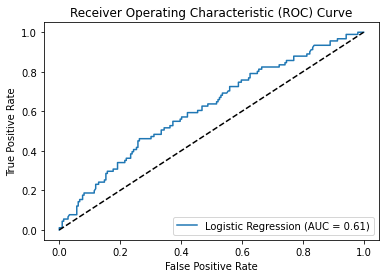

In [356]:
# Define the weights for each class
class_counts = y_train.value_counts()
total_samples = len(y_train)

# Calculate the weight for each class
weight_0 = total_samples / (2 * class_counts[0])
weight_1 = total_samples / (2 * class_counts[1]) 

model = LogisticRegression(class_weight={0: weight_0, 1: weight_1})
model.fit(X_train, y_train)

# Model validation
X_valid = transformed_valid_df[selected_feature_names]
y_valid = transformed_valid_df[target]
y_pred = model.predict(X_valid)
y_pred_proba = model.predict_proba(X_valid)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred, zero_division=1)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
auc = roc_auc_score(y_valid, y_pred_proba)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# # Perform sensitivity analysis (example with age variable)
# sensitivity_variable = 'age'
# sensitivity_values = [0.9, 1.0, 1.1]  # Adjust the variable by 10% in each case

# for value in sensitivity_values:
#     X_sensitivity = transformed_valid_df[independent_vars].copy()
#     X_sensitivity[sensitivity_variable] *= value  # Adjust the variable
#     y_sensitivity = transformed_valid_df[target]
    
#     # Calculate performance metrics for sensitivity analysis
#     y_pred_sensitivity = model.predict(X_sensitivity)
#     y_pred_proba_sensitivity = model.predict_proba(X_sensitivity)[:, 1]
#     accuracy_sensitivity = accuracy_score(y_sensitivity, y_pred_sensitivity)
#     precision_sensitivity = precision_score(y_sensitivity, y_pred_sensitivity)
#     recall_sensitivity = recall_score(y_sensitivity, y_pred_sensitivity)
#     f1_sensitivity = f1_score(y_sensitivity, y_pred_sensitivity)
#     auc_sensitivity = roc_auc_score(y_sensitivity, y_pred_proba_sensitivity)

#     print(f"Sensitivity Value: {value}")
#     print(f"Accuracy: {accuracy_sensitivity}")
#     print(f"Precision: {precision_sensitivity}")
#     print(f"Recall: {recall_sensitivity}")
#     print(f"F1 Score: {f1_sensitivity}")
#     print(f"AUC: {auc_sensitivity}")
#     print("-------------------------------------")

In [357]:
def calculate_frequencies(df):
    frequencies = {}
    
    for col in df.columns:
        values = df[col].value_counts(normalize=True)
        frequencies[col] = values
    
    return frequencies

freq_counts = calculate_frequencies(X_valid)
for col, values in freq_counts.items():
    print(f"Frequencies for column '{col}':")
    print(values)
    print()

Frequencies for column 'Age':
0.0024    0.2167
0.3110    0.2100
-0.1778   0.1833
0.5578    0.1233
-0.2880   0.0833
-0.3499   0.0800
-0.7214   0.0533
-0.2445   0.0500
Name: Age, dtype: float64

Frequencies for column 'Sex':
-0.1411   0.7067
0.2803    0.2933
Name: Sex, dtype: float64

Frequencies for column 'Housing':
-0.2181   0.7033
0.3868    0.1900
0.6428    0.1067
Name: Housing, dtype: float64

Frequencies for column 'Credit amount':
-0.0781   0.2500
-0.1755   0.2233
-0.2665   0.1800
-0.3160   0.1267
0.6357    0.1133
-0.4958   0.1067
Name: Credit amount, dtype: float64

Frequencies for column 'Duration':
-0.2296   0.2433
-0.0214   0.2167
0.1217    0.1267
-1.2253   0.1100
-0.3780   0.1033
0.8541    0.0767
0.7874    0.0767
0.0518    0.0467
Name: Duration, dtype: float64

Frequencies for column 'Purpose':
0.1485    0.3167
-0.5137   0.2600
-0.0802   0.2133
0.3841    0.1067
0.5822    0.0733
-0.0214   0.0167
0.4486    0.0067
0.8541    0.0067
Name: Purpose, dtype: float64



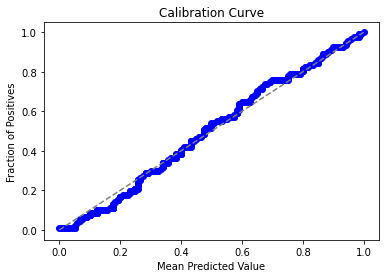

In [358]:
# Define the observed and expected frequencies
observed_freq = y_valid
expected_freq = y_pred

# Compute the fraction of positives and mean predicted values
fraction_of_positives = np.cumsum(observed_freq) / np.sum(observed_freq)
mean_predicted_value = np.cumsum(expected_freq) / np.sum(expected_freq) + 1e-8

# Plot the calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linestyle='-', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.show()

In [359]:
"""If the calibration curve appears to be aligned closely with the diagonal dashed line, it suggests good calibration. This alignment indicates that the predicted probabilities are well-calibrated and correspond well with the observed frequencies.

In such a case, even if the p-value from the Hosmer-Lemeshow test is NaN or cannot be computed, it does not necessarily imply a problem with the calibration. The visual inspection of the calibration plot is often sufficient to assess the calibration quality.

Therefore, based on the aligned calibration curve, you can conclude that the model's predicted probabilities are well-calibrated and provide accurate estimates of the probabilities of the events."""

"If the calibration curve appears to be aligned closely with the diagonal dashed line, it suggests good calibration. This alignment indicates that the predicted probabilities are well-calibrated and correspond well with the observed frequencies.\n\nIn such a case, even if the p-value from the Hosmer-Lemeshow test is NaN or cannot be computed, it does not necessarily imply a problem with the calibration. The visual inspection of the calibration plot is often sufficient to assess the calibration quality.\n\nTherefore, based on the aligned calibration curve, you can conclude that the model's predicted probabilities are well-calibrated and provide accurate estimates of the probabilities of the events."

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of log odds
plt.hist(log_odds, bins=20)
plt.xlabel('Log Odds')
plt.ylabel('Frequency')
plt.title('Distribution of Log Odds')
plt.show()

# Plot the distribution of predicted probabilities
plt.hist(y_pred_proba, bins=20)
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

In [369]:
# Define the desired score range
score_min = 400
score_max = 800

# Define the target log odds doubling interval
log_odds_interval = 10

# Calculate the target log odds doubling factor
target_log_odds_factor = np.log(2)

# # Calculate the log odds
# log_odds = np.log(y_pred_proba / (1 - y_pred_proba))

# # Calculate the scaling factor for mapping the log odds to the score range
# scaling_factor = (score_max - score_min) / (target_log_odds_factor * (score_max - score_min) / log_odds_interval)

# # Calculate the intercept for adjusting the scores
# intercept = score_min - (scaling_factor * np.min(log_odds) // log_odds_interval) * log_odds_interval

from scipy.special import expit

# Calculate the logits (inverse of the logistic function)
logits = np.log(y_pred_proba / (1 - y_pred_proba))

# Apply the logistic function (sigmoid) to the logits
prob_transformed = expit(logits)

# Map the transformed probabilities to the score range
scores = np.round(prob_transformed * (score_max - score_min) + score_min).astype(int)

In [403]:
score_letters = []

for score in scores:
    if score < 500:
        score_letters.append('A')
    elif score < 550:
        score_letters.append('B')
    elif score < 600:
        score_letters.append('C')
    elif score < 650:
        score_letters.append('D')
    elif score < 700:
        score_letters.append('E')
    elif score < 750:
        score_letters.append('F')
    elif score <= 800:
        score_letters.append('G')
    else:
        score_letters.append('H')

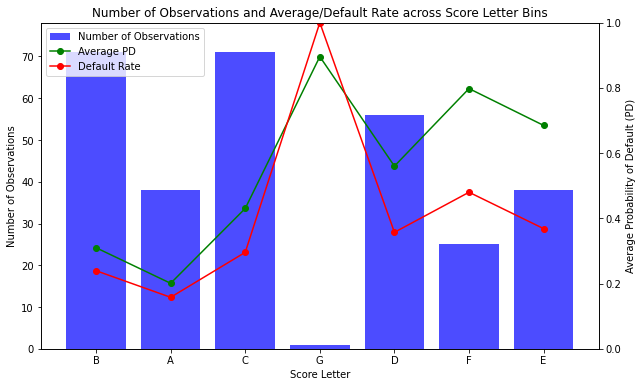

In [404]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the number of observations in each letter bin
letter_counts = {letter: score_letters.count(letter) for letter in set(score_letters)}

# Calculate the average PD in each letter bin
letter_avg_pds = {letter: np.mean(y_pred_proba[np.array(score_letters) == letter]) for letter in set(score_letters)}

# Calculate the default rate in each letter bin
letter_default_rates = {letter: np.mean(y_valid[np.array(score_letters) == letter]) for letter in set(score_letters)}

# Create a list to store the x-axis values
x = list(set(score_letters))

# Create a list to store the y-axis values for letter counts
counts = [letter_counts[letter] for letter in x]

# Create a list to store the y-axis values for average PDs
avg_pds = [letter_avg_pds[letter] for letter in x]

# Create a list to store the y-axis values for default rates
default_rates = [letter_default_rates[letter] for letter in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot the number of observations in each letter bin
ax1.bar(x, counts, color='blue', alpha=0.7, label='Number of Observations')
ax1.set_ylabel('Number of Observations')
ax1.set_ylim(0, max(counts) * 1.1)

# Plot the average PD in each letter bin
ax2.plot(x, avg_pds, marker='o', color='green', label='Average PD')
ax2.set_ylabel('Average Probability of Default (PD)')
ax2.set_ylim(0, 1)

# Plot the default rate in each letter bin
ax2.plot(x, default_rates, marker='o', color='red', label='Default Rate')

# Set labels and title
ax1.set_xlabel('Score Letter')
ax1.set_title('Number of Observations and Average/Default Rate across Score Letter Bins')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Show the plot
plt.show()

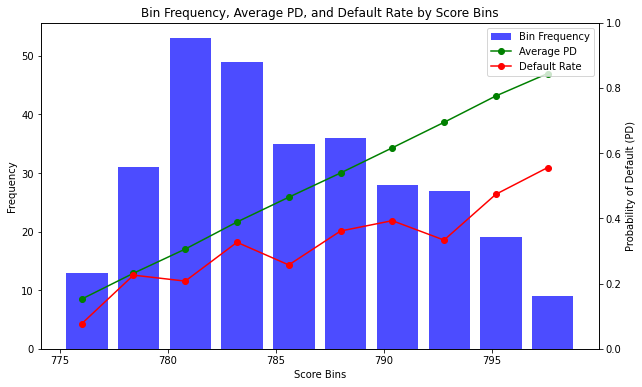

In [418]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a DataFrame with scores, y_pred_proba, and y_valid
data = pd.DataFrame({'Score': scores, 'PD': y_pred_proba, 'Default': y_valid})

# Define the number of bins and bin width
num_bins = 10
bin_width = (score_max - score_min) / num_bins

# Create a new column in the DataFrame to represent the bins
data['Bin'] = pd.cut(data['Score'], bins=num_bins, labels=False)

# Calculate the bin frequencies
bin_counts = data['Bin'].value_counts().sort_index()

# Group the data by the bin and calculate the average PD and default rate
bin_stats = data.groupby('Bin').agg({'PD': 'mean', 'Default': 'mean'})

# Create a list of bin boundaries for plotting
bin_boundaries = [score_min + i * bin_width for i in range(num_bins+1)]

# Calculate the bar width and position
bar_width = bin_width * 0.8
bar_position = np.array(bin_boundaries[:-1]) + bin_width * 0.1

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot the bin frequencies as a bar plot with separation
ax1.bar(bar_position, bin_counts, width=bar_width, align='center', color='blue', alpha=0.7, label='Bin Frequency')
ax1.set_ylabel('Frequency')

# Plot the average PD as a line
ax2.plot(bin_boundaries[:-1], bin_stats['PD'], marker='o', color='green', label='Average PD')
ax2.set_ylabel('Probability of Default (PD)')
ax2.set_ylim(0, 1)

# Plot the default rate as a line
ax2.plot(bin_boundaries[:-1], bin_stats['Default'], marker='o', color='red', label='Default Rate')

# Set labels and title
ax1.set_xlabel('Score Bins')
ax1.set_title('Bin Frequency, Average PD, and Default Rate by Score Bins')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()